In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv(r"C:\Users\Hp\Downloads\elevvo internship\Task 3\Online Retail.csv")
df


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09/12/2011 12:50,4.15,12680.0,France


In [10]:
# Keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [12]:
# Remove missing Customer IDs
df = df.dropna(subset=['CustomerID'])

In [13]:
# Create Total Amount column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [17]:
# Force day-first parsing; coerce any weird rows to NaT
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')

# Drop rows that still failed to parse (optional)
df = df.dropna(subset=['InvoiceDate'])


### **Calculate RFM Metrics**

In [18]:
# Reference date (max date in dataset + 1 day)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalAmount': 'sum'                                      # Monetary
})

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalAmount': 'Monetary'}, inplace=True)


### **Assign RFM Scores**

In [19]:
# Recency: lower days = better score (reverse ranking)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency & Monetary: higher is better
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine scores
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)


**Segment Customers**

In [20]:
def segment_customer(df):
    if df['R_score'] >= 4 and df['F_score'] >= 4:
        return 'Champions'
    elif df['R_score'] >= 3 and df['F_score'] >= 3:
        return 'Loyal Customers'
    elif df['R_score'] >= 4 and df['F_score'] <= 2:
        return 'Recent Customers'
    elif df['R_score'] <= 2 and df['F_score'] >= 4:
        return 'At Risk'
    else:
        return 'Needs Attention'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


### **Visualize Segments**

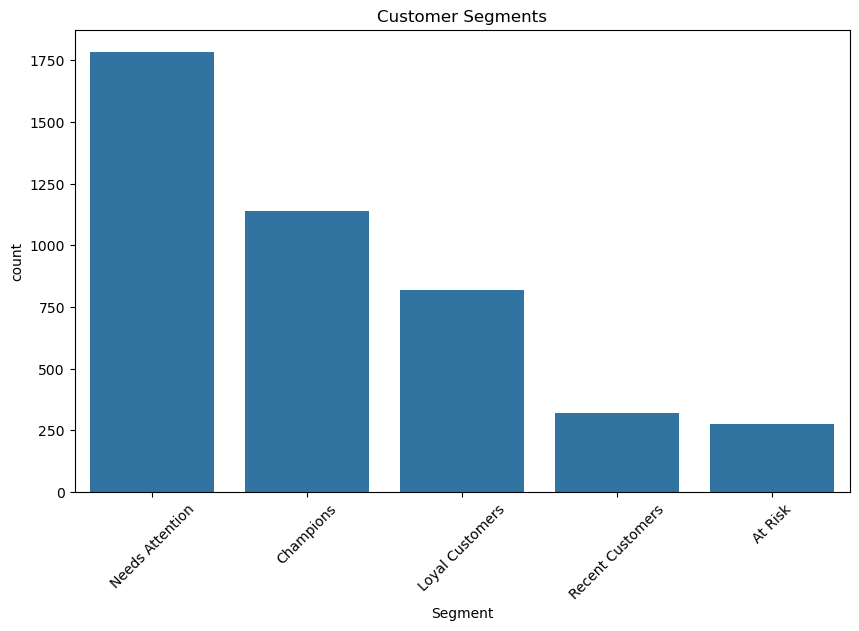

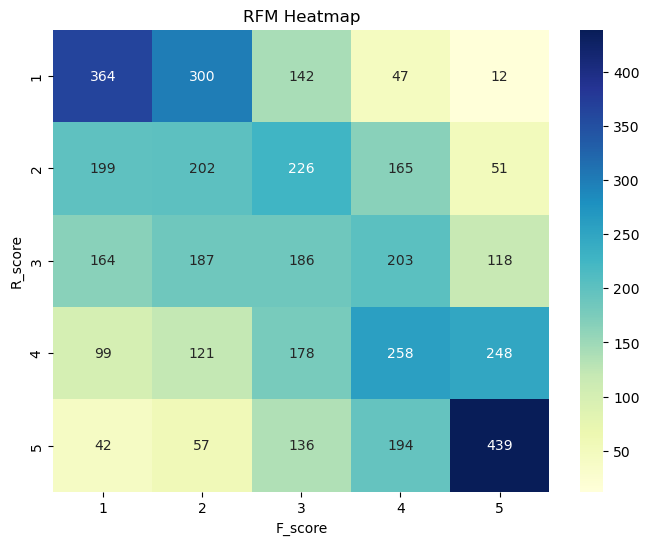

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.xticks(rotation=45)
plt.show()

# heatmap
rfm_pivot = rfm.groupby(['R_score','F_score']).size().unstack(fill_value=0)
plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title('RFM Heatmap')
plt.show()


In [22]:
rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,Needs Attention
12347.0,2,7,4310.00,5,5,5,555,Champions
12348.0,75,4,1797.24,2,4,4,244,At Risk
12349.0,19,1,1757.55,4,1,4,414,Recent Customers
12350.0,310,1,334.40,1,1,2,112,Needs Attention
